In [1]:
import time
from torch import nn, optim
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Load the dataset
df = pd.read_csv('dataset.csv')

from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# Load the MobileNetV3 Large model
weights = MobileNet_V3_Large_Weights.DEFAULT
model = mobilenet_v3_large(weights=weights)

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Custom dataset
class ClothingDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            img_name = self.dataframe.iloc[idx, 0]
            img_path = f"images/{img_name}.png"
            image = Image.open(img_path).convert("RGB")
            labels = self.dataframe.iloc[idx, 1:].values.astype(np.float32)
            if self.transform:
                image = self.transform(image)
            return image, labels
        except FileNotFoundError:
            # print(f"File {img_path} not found. Skipping index {idx}.")
            return None

# Create dataset instances
dataset = ClothingDataset(df, transform=preprocess)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

def custom_collate_fn(batch):
    # Filter out None values
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)

batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)


In [2]:
# Freeze the feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Modify the model to match the number of classes in the dataset
num_classes = df.shape[1] - 1

# Add dropout before the final fully connected layer
model.classifier[3] = nn.Sequential(
    nn.Dropout(p=0.2),  # 20% dropout
    nn.Linear(model.classifier[3].in_features, num_classes)
)

# Unfreeze the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    corrects = (preds == labels).float().sum().item()
    return corrects / labels.numel()

cuda


In [10]:
# Training and validation loop
num_epochs = 50
patience = 5
best_val_loss = float('inf')  # Keep track of the best validation loss
no_improvement_epochs = 0  # Counter for epochs with no improvement

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0.0
    num_batches = 0  # Counter for valid batches
    for images, labels in train_loader:
        if images is None or labels is None:
            continue
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += calculate_accuracy(outputs, labels)
        num_batches += 1
    
    if num_batches > 0:
        train_loss = running_loss / num_batches
        train_acc = running_corrects / num_batches
    else:
        train_loss = float('inf')
        train_acc = 0.0
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0.0
    num_batches = 0  # Counter for valid batches
    with torch.no_grad():
        for images, labels in val_loader:
            if images is None or labels is None:
                continue
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_corrects += calculate_accuracy(outputs, labels)
            num_batches += 1
    
    if num_batches > 0:
        val_loss = val_loss / num_batches
        val_acc = val_corrects / num_batches
    else:
        val_loss = float('inf')
        val_acc = 0.0
    
    # Step the learning rate scheduler
    scheduler.step()
    
    elapsed_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Time: {elapsed_time:.2f}s, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}")
    
    # Save the model if the validation loss is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"best_mobile_model_{val_loss:.4f}_{val_acc:.4f}.pth")
        print(f"Saved model with Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        no_improvement_epochs = 0  # Reset counter
    else:
        no_improvement_epochs += 1
        print(f"No improvement for {no_improvement_epochs} epochs.")
    
    # Early stopping
    if no_improvement_epochs >= patience:
        print("Early stopping triggered.")
        break

print("Training complete")

C:\Users\jasper\PycharmProjects\preloved-auto-tag\.venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/50], Time: 2197.27s, Train Loss: 0.1970, Train Acc: 0.9372, Val Loss: 0.1631, Val Acc: 0.9443
Saved model with Val Loss: 0.1631, Val Acc: 0.9443
Epoch [2/50], Time: 2311.23s, Train Loss: 0.1624, Train Acc: 0.9441, Val Loss: 0.1588, Val Acc: 0.9453
Saved model with Val Loss: 0.1588, Val Acc: 0.9453
Epoch [3/50], Time: 2354.22s, Train Loss: 0.1559, Train Acc: 0.9457, Val Loss: 0.1561, Val Acc: 0.9462
Saved model with Val Loss: 0.1561, Val Acc: 0.9462
Epoch [4/50], Time: 3092.22s, Train Loss: 0.1510, Train Acc: 0.9471, Val Loss: 0.1550, Val Acc: 0.9465
Saved model with Val Loss: 0.1550, Val Acc: 0.9465
Epoch [5/50], Time: 2281.98s, Train Loss: 0.1465, Train Acc: 0.9482, Val Loss: 0.1541, Val Acc: 0.9467
Saved model with Val Loss: 0.1541, Val Acc: 0.9467
Epoch [6/50], Time: 2263.16s, Train Loss: 0.1398, Train Acc: 0.9499, Val Loss: 0.1525, Val Acc: 0.9474
Saved model with Val Loss: 0.1525, Val Acc: 0.9474
Epoch [7/50], Time: 2177.73s, Train Loss: 0.1387, Train Acc: 0.9502, Val Los

KeyboardInterrupt: 

In [11]:
# Test loop
model.load_state_dict(torch.load("best_mobile_model_0.1519_0.9475.pth"))  # Load the best model
model.eval()
test_loss = 0.0
test_corrects = 0.0
num_batches = 0  # Counter for valid batches
with torch.no_grad():
    for images, labels in test_loader:
        if images is None or labels is None:
            continue
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_corrects += calculate_accuracy(outputs, labels)
        num_batches += 1

if num_batches > 0:
    test_loss = test_loss / num_batches
    test_acc = test_corrects / num_batches
else:
    test_loss = float('inf')
    test_acc = 0.0

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

C:\Users\jasper\PycharmProjects\preloved-auto-tag\.venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Loss: 0.1529, Test Acc: 0.9473


In [26]:
# Load the model state
model.load_state_dict(torch.load('best_mobile_model_0.1519_0.9475.pth'))
model.eval()  # Set model to evaluation mode

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [27]:
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0)  # Preprocess and add batch dimension
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold
    
    return preds.cpu().numpy(), image

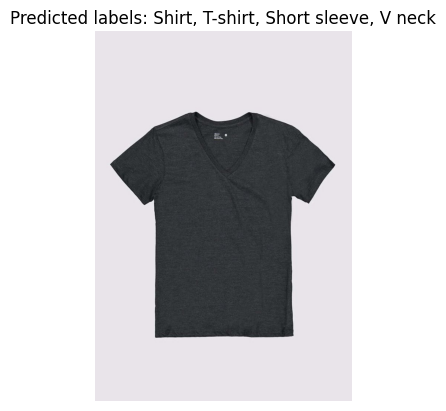

In [30]:
import matplotlib.pyplot as plt
# Example usage
image_path = 'gua0128gy4_fl_f_za_6.jpg'  # Update this path to your image
predictions, image = predict(image_path)

# Convert predictions to a readable format
labels = df.columns[1:]  # Assuming first column is 'Image name'
predicted_labels = {label: bool(pred) for label, pred in zip(labels, predictions[0])}

# Filter only the true labels
true_labels = [label for label, is_true in predicted_labels.items() if is_true]

# Display the image with predicted labels
plt.imshow(image)
plt.title("Predicted labels: " + ", ".join(true_labels))
plt.axis('off')  # Hide the axes
plt.show()

In [6]:
model.load_state_dict(torch.load("best_mobile_modelV3_0.1519_0.9475.pth"))  # Load the best model
torch.save(model, "V3_model.pth")